# Here is a small-scale example for training deep-learning models for P/S wave arrival picking

In [1]:
# References:
# Cui, Y., M. Bai, J. Wu, and Y. Chen, 2025, Earthquake signal detection using a multiscale feature fusion network with hybrid attention mechanism, GJI, 988-1008
# Saad, O.M., Chen, Y.F., Siervo, D., Zhang, F., Savvaidis, A., Huang, G., Igonin, N., Fomel, S., and Chen, Y., (2023), as a highly accurate and generalizable machine-learning seismic event detection algorithm, IEEE TGRS.
# Chen et al., 2024, Near Real‐Time Earthquake Monitoring in Texas Using the Highly Precise Deep Learning Phase Picker, Earth and Space Science, 11, e2024EA003890.
# 

In [2]:
#conda activate eqp

# import library
import numpy as np
import h5py
# import random
# import os
# import sys


# # Make a new dir to save the picking error
# directory_path = "./train_data_picking/"

# # Create the directory, including any necessary parent directories
# os.makedirs(directory_path, exist_ok=True)


In [3]:
# Load the TXED dataset
# please down load the TXED from: https://drive.google.com/drive/folders/1WXVB8ytNB4bOaZ97oq6OmMRyAEg95trp?usp=sharing
f_txed = h5py.File("/Users/chenyk/DATALIB/TXED/TXED_20231111.h5", 'r')
txed_signal_id = np.load("/Users/chenyk/DATALIB/TXED/ID_20231111.npy", 'r')[0:100000].copy()
np.random.seed(20232425)
np.random.shuffle(txed_signal_id)
txed_signal_id=txed_signal_id[0:10000]
print(txed_signal_id[0:10]) #see if the random IDs are the same


['texnet2022nlpv_PB31_EV' 'texnet2021bbcd_POST_EV'
 'texnet2020znsu_OG02_EV' 'texnet2021ojgr_PB16_EV'
 'texnet2021ghba_EF04_EV' 'texnet2020yuzo_MB07_EV'
 'texnet2021gqdj_MB07_EV' 'texnet2022mqlw_PB03_EV'
 'texnet2023ihss_PB44_EV' 'texnet2021wmup_PB09_EV']


# Design a DL architecture for P/S arrival picking

In [4]:
# Below example is from 
# Cui, Y., M. Bai, J. Wu, and Y. Chen, 2025, Earthquake signal detection using a multiscale feature fusion network with hybrid attention mechanism, GJI, 988-1008
#

from keras.layers import Input, Dense, Conv1D, Dropout, Activation, Flatten, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler, CSVLogger
from keras.layers import concatenate,LeakyReLU,GlobalAveragePooling1D,Multiply,Reshape,Lambda,Add,GRU
from keras.layers import BatchNormalization,UpSampling1D
from keras.models import Model
# from keras.optimizers import Adam
from keras.optimizers.legacy import Adam
from keras import backend as K

D1, D2, D3, D4 = 64, 32, 16, 8 # number of filters in different layers
k1, k2, k3 = 3, 6, 9 # kernel sizes in MSFF model

# define hybrids attention model
def channel_attention(input_tensor, reduction_ratio=16):
    channel_avg = GlobalAveragePooling1D()(input_tensor)
    channel_dense1 = Dense(units=int(input_tensor.shape[-1]) // reduction_ratio, activation='relu')(channel_avg)
    channel_dense2 = Dense(units=int(input_tensor.shape[-1]), activation='sigmoid')(channel_dense1)
    channel_attention = Multiply()([input_tensor, Reshape(target_shape=(1, -1))(channel_dense2)])
    return channel_attention

def spatial_attention(input_tensor):
    spatial_avg = Lambda(lambda x: K.mean(x, axis=2))(input_tensor)
    spatial_max = Lambda(lambda x: K.max(x, axis=2))(input_tensor)
    spatial_concat = Reshape(target_shape=(-1, 2))(concatenate([spatial_avg, spatial_max],axis=1))
    spatial_conv1 = Conv1D(filters=1, kernel_size=3, padding='same', activation='sigmoid')(spatial_concat)
    spatial_attention = Multiply()([input_tensor, Reshape(target_shape=(-1, 1))(spatial_conv1)])
    return spatial_attention

def cbam_block(input_tensor):
    channel_att = channel_attention(input_tensor)
    spatial_att = spatial_attention(channel_att)
    cbam_output = Add()([channel_att, spatial_att])
    return cbam_output
    
# define encoder block
inp = Input(shape=(6000, 3))

# encoder block
encoder1 = Dense(D1, activation='relu')(inp)
mixed_1 = Conv1D(D1, kernel_size=k1, strides=2, padding='same', activation='linear')(encoder1)
mixed_2 = Conv1D(D1, kernel_size=k2, strides=2, padding='same', activation='linear')(encoder1)
mixed_3 = Conv1D(D1, kernel_size=k3, strides=2, padding='same', activation='linear')(encoder1)
encoder1 = concatenate([mixed_1, mixed_2, mixed_3], axis=-1)
encoder1 = LeakyReLU(0.2)(encoder1)
encoder1 = Dropout(0.1)(encoder1)

attention1 = cbam_block(encoder1)

encoder2 = Dense(D2, activation='relu')(attention1)
encoder2_0 = Conv1D(D2, kernel_size=k1, strides=2, padding='same')(encoder2)
encoder2_1 = Conv1D(D2, kernel_size=k2, strides=2, padding='same')(encoder2)
encoder2_2 = Conv1D(D2, kernel_size=k3, strides=2, padding='same')(encoder2)
encoder2 = concatenate([encoder2_0, encoder2_1, encoder2_2], axis=-1)
encoder2 = LeakyReLU(0.2)(encoder2)
encoder2 = Dropout(0.1)(encoder2)

attention2 = cbam_block(encoder2)

encoder3 = Dense(D3, activation='relu')(attention2)
encoder3_0 = Conv1D(D3, kernel_size=k1, strides=2, padding='same')(encoder3)
encoder3_1 = Conv1D(D3, kernel_size=k2, strides=2, padding='same')(encoder3)
encoder3_2 = Conv1D(D3, kernel_size=k3, strides=2, padding='same')(encoder3)
encoder3 = concatenate([encoder3_0, encoder3_1, encoder3_2], axis=-1)
encoder3 = LeakyReLU(0.2)(encoder3)
encoder3 = Dropout(0.1)(encoder3)

attention3 = cbam_block(encoder3)

encoder4 = Dense(D4, activation='relu')(encoder3)
encoder4_0 = Conv1D(D4, kernel_size=k1, strides=2, padding='same')(encoder4)
encoder4_1 = Conv1D(D4, kernel_size=k2, strides=2, padding='same')(encoder4)
encoder4_2 = Conv1D(D4, kernel_size=k3, strides=2, padding='same')(encoder4)
encoder4 = concatenate([encoder4_0, encoder4_1, encoder4_2], axis=-1)
encoder4 = LeakyReLU(0.2)(encoder4)
encoder4 = Dropout(0.1)(encoder4)

attention4 = cbam_block(encoder4)

# define bottleneck block
bottleneck = GRU(units=32, activation='tanh', return_sequences=True)(attention4) 
bottleneck = GRU(units=8, activation='tanh', return_sequences=True)(bottleneck)  
bottleneck = Flatten()(bottleneck)
encoder = Dense(2, activation='softmax')(bottleneck)


# define the classification model in latent layer
# Clas_model = Model(inputs=inp, outputs=encoder, name='encoder')
# Clas_model.summary()

# define decoder blocks
decoder4 = Dense(D4, activation='relu')(encoder4)
decoder4_0 = Conv1D(D4, k1, padding='same')(decoder4)
decoder4_1 = Conv1D(D4, k2, padding='same')(decoder4)
decoder4_2 = Conv1D(D4, k3, padding='same')(decoder4)
decoder4 = concatenate([decoder4_0, decoder4_1, decoder4_2], axis=-1)
decoder4 = LeakyReLU(0.2)(decoder4)
decoder4 = BatchNormalization()(decoder4)
decoder4 = concatenate([decoder4, attention4], axis=-1)
decoder4 = UpSampling1D(2)(decoder4)

decoder3 = Dense(D3, activation='relu')(decoder4)
decoder3_0 = Conv1D(D3, k1, padding='same')(decoder3)
decoder3_1 = Conv1D(D3, k2, padding='same')(decoder3)
decoder3_2 = Conv1D(D3, k3, padding='same')(decoder3)
decoder3 = concatenate([decoder3_0, decoder3_1, decoder3_2], axis=-1)
decoder3 = LeakyReLU(0.2)(decoder3)
decoder3 = BatchNormalization()(decoder3)
decoder3 = concatenate([decoder3, attention3], axis=-1)
decoder3 = UpSampling1D(2)(decoder3)

decoder2 = Dense(D2, activation='relu')(decoder3)
decoder2_0 = Conv1D(D2, k1, padding='same')(decoder2)
decoder2_1 = Conv1D(D2, k2, padding='same')(decoder2)
decoder2_2 = Conv1D(D2, k3, padding='same')(decoder2)
decoder2 = concatenate([decoder2_0, decoder2_1, decoder2_2], axis=-1)
decoder2 = LeakyReLU(0.2)(decoder2)
decoder2 = BatchNormalization()(decoder2)
decoder2 = concatenate([decoder2, attention2], axis=-1)
decoder2 = UpSampling1D(2)(decoder2)

decoder1 = Dense(D1, activation='relu')(decoder2)
decoder1_0 = Conv1D(D1, k1, padding='same')(decoder1)
decoder1_1 = Conv1D(D1, k2, padding='same')(decoder1)
decoder1_2 = Conv1D(D1, k3, padding='same')(decoder1)
decoder1 = concatenate([decoder1_0, decoder1_1, decoder1_2], axis=-1)
decoder1 = LeakyReLU(0.2)(decoder1)
decoder1 = BatchNormalization()(decoder1)
decoder1 = concatenate([decoder1, attention1], axis=-1)
decoder1 = UpSampling1D(2)(decoder1)



# define the output block of the phase-picking network
decoder1 = Dense(D1, activation='relu')(decoder1)
decoder = Conv1D(2, 3, padding='same', activation='sigmoid')(decoder1)

# define the picking model using all layers
picking_model = Model(inputs=inp, outputs=decoder)
picking_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6000, 3)]            0         []                            
                                                                                                  
 dense (Dense)               (None, 6000, 64)             256       ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 3000, 64)             12352     ['dense[0][0]']               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 3000, 64)             24640     ['dense[0][0]']               
                                                                                              

In [5]:
## Define a band-pass filter

from scipy.signal import butter, lfilter, lfilter_zi

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
    
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    zi = lfilter_zi(b, a)
    y,zo = lfilter(b, a, data, zi=zi*data[0])
    return y

def generate_first_arrival_labels(p_indx, s_indx, sample_num):
    """
    Generate labels for P-wave and S-wave first arrival picking.

    Parameters:
        p_indx (float): Arrival time of P-wave.
        s_indx (float): Arrival time of S-wave.
        sample_num (float): Total duration of the seismic signal.

    Returns:
        np.array: Array of labels indicating P-wave, S-wave, or neither.
    """
    all_time = np.linspace(0, sample_num, sample_num)
    #print(sample_num, all_time.shape)
    p_wave_arrival_time = p_indx  # P-wave arrival time (in seconds)
    s_wave_arrival_time = s_indx  # S-wave arrival time (in seconds)
    
    # Create Gaussian-shaped labels for P-wave and S-wave arrivals
    sigma = 10 # Standard deviation of the Gaussian
    p_wave_label = np.exp(-(all_time - p_wave_arrival_time)**2 / (2 * sigma**2))  # Gaussian label for P-wave
    s_wave_label = np.exp(-(all_time - s_wave_arrival_time)**2 / (2 * sigma**2))  # Gaussian label for S-wave

    return p_wave_label, s_wave_label

In [6]:
# obtain the P- and S-wave arrivals
P_arrival_list = []
S_arrival_list = []
print('-----------arrival time calculation begin-------------------')
for key in txed_signal_id:
    if key in f_txed:   
        dataset = f_txed.get(key)
        P_arrival_list.append(int(dataset.attrs['p_arrival_sample']))
        S_arrival_list.append(int(dataset.attrs['s_arrival_sample']))
P_arrival_list = np.array(P_arrival_list)
S_arrival_list = np.array(S_arrival_list)
P_phase_label_indx = P_arrival_list
S_phase_label_indx = S_arrival_list
P_phase_label_indx = np.reshape(P_phase_label_indx, [P_phase_label_indx.shape[0], 1])
S_phase_label_indx = np.reshape(S_phase_label_indx, [S_phase_label_indx.shape[0], 1])
phase_label_indx = np.concatenate([P_phase_label_indx, S_phase_label_indx], axis=-1)
print('-----------arrival time calculation end-------------------')
print(f'shape of arrivals: {P_arrival_list.shape}')


# apply the bandpass and normalize to each waveform
signal_list = []
print('-----------signal format convert begin-------------------')
for key in txed_signal_id:
    if key in f_txed:   
        dataset = f_txed.get(key)
        datas = dataset['data']
        datas = np.array(datas)
        datas_0 = bandpass_filter(datas[:,0], 1, 45, 100, order=3)
        datas_1 = bandpass_filter(datas[:,1], 1, 45, 100, order=3)
        datas_2 = bandpass_filter(datas[:,2], 1, 45, 100, order=3)
        datas = np.vstack([datas_0, datas_1, datas_2])
        signal_list.append(datas) 
signal_values = np.array(signal_list)
bp_signal= np.transpose(signal_values, [0, 2, 1])


#Normalized trace-by-trace
max_values_per_event = np.max(bp_signal, axis=1)
# Normalize each component of each event by dividing by its maximum value
normalized_phase_data = bp_signal / max_values_per_event[:, np.newaxis, :]
print('-----------signal format convert finish-------------------')
print(bp_signal.shape)

p_wave_label = []
s_wave_label = []
for i in range (normalized_phase_data.shape[0]):
    # Example usage:
    p_indx = P_arrival_list[i]  # Arrival time of P-wave (in seconds)
    s_indx = S_arrival_list[i]  # Arrival time of S-wave (in seconds)    
    sample_num = 6000  # Sampling rate of seismic signal (in Hz)
    #print(f'Processed_num:{i}\t P_arrival_time: {p_indx}\t S_arrival_time: {s_indx}\t sample_num: {sample_num}')
    if i % 5000 == 0:
        print(f'Processed_num: {i}\t P_arrival_time: {p_indx}\t S_arrival_time: {s_indx}\t sample_num: {sample_num}')
    
    # Generate labels for P-wave and S-wave first arrival picking
    p_labels, s_labels = generate_first_arrival_labels(p_indx, s_indx, sample_num)
    p_wave_label.append(p_labels)  
    s_wave_label.append(s_labels)
p_wave_label = np.array(p_wave_label)
s_wave_label = np.array(s_wave_label)
phase_label = np.concatenate([np.reshape(p_wave_label, [p_wave_label.shape[0], p_wave_label.shape[1], 1]), \
                              np.reshape(s_wave_label, [s_wave_label.shape[0], s_wave_label.shape[1], 1])], axis=-1)


-----------arrival time calculation begin-------------------
-----------arrival time calculation end-------------------
shape of arrivals: (10000,)
-----------signal format convert begin-------------------
-----------signal format convert finish-------------------
(10000, 6000, 3)
Processed_num: 0	 P_arrival_time: 1023	 S_arrival_time: 1563	 sample_num: 6000
Processed_num: 5000	 P_arrival_time: 524	 S_arrival_time: 707	 sample_num: 6000


In [7]:
from sklearn.model_selection import train_test_split

# Data splitting for EQ detection
X_train_phase, X_test_phase, y_train_phase, y_test_phase = train_test_split(normalized_phase_data, phase_label, test_size=0.15, random_state=202404)
print('X_train_phase shape', X_train_phase.shape, 'X_test_phase shape', X_test_phase.shape)

X_train_phase shape (8500, 6000, 3) X_test_phase shape (1500, 6000, 3)


In [8]:
import os
## Start the training process
log_path = './training_model/logs/'
save_model_path = './training_model/'
fig_path = './figs/'

os.makedirs(save_model_path, exist_ok=True)
os.makedirs(log_path , exist_ok=True)
os.makedirs(fig_path , exist_ok=True)

val_splitting_rate = 0.05 # ratio of validation data
learning_rate = 0.001 # Specify the learning rate
phase_batch = 256 # batch size for picking
phase_epoch = 20 #number of iterations

optimizer = Adam(learning_rate=learning_rate)

# train the picking model
picking_model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])

csv_logger = CSVLogger(f'{log_path}EQ_picking_logs.csv')


# Addig stopping condition
es=EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
mc=ModelCheckpoint(f'{save_model_path}EQ_picking_best_model_new.h5', monitor='val_loss', mode='min', save_best_only=True)


# Tic-Toc
import time
start=time.time()
history_phase = picking_model.fit(X_train_phase, y_train_phase, verbose=1, epochs=phase_epoch,
                                  validation_split=val_splitting_rate, shuffle=True, batch_size=phase_batch, callbacks=[csv_logger, es, mc])
end = time.time()
running_time = end - start
print('time cost od picking model: %.4f sec' % running_time)



Epoch 1/20
32/32 [==============================] - 148s 4s/step - loss: 0.1064 - accuracy: 0.4628 - val_loss: 0.3593 - val_accuracy: 0.0425
Epoch 2/20


/opt/anaconda3/envs/eqp/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 501s 16s/step - loss: 0.0205 - accuracy: 0.6132 - val_loss: 0.2107 - val_accuracy: 0.0427
Epoch 3/20
32/32 [==============================] - 919s 29s/step - loss: 0.0188 - accuracy: 0.6839 - val_loss: 0.1341 - val_accuracy: 0.4502
Epoch 4/20
32/32 [==============================] - 118s 4s/step - loss: 0.0163 - accuracy: 0.6665 - val_loss: 0.0899 - val_accuracy: 0.7919
Epoch 5/20
32/32 [==============================] - 191s 6s/step - loss: 0.0147 - accuracy: 0.7056 - val_loss: 0.0655 - val_accuracy: 0.8257
Epoch 6/20
32/32 [==============================] - 121s 4s/step - loss: 0.0138 - accuracy: 0.7239 - val_loss: 0.0487 - val_accuracy: 0.8107
Epoch 7/20
32/32 [==============================] - 303s 10s/step - loss: 0.0133 - accuracy: 0.7340 - val_loss: 0.0378 - val_accuracy: 0.7951
Epoch 8/20
32/32 [==============================] - 608s 19s/step - loss: 0.0128 - accuracy: 0.7473 - val_loss: 0.0301 - val_accuracy: 0.7780
Epoch 9/20
32/32 [==

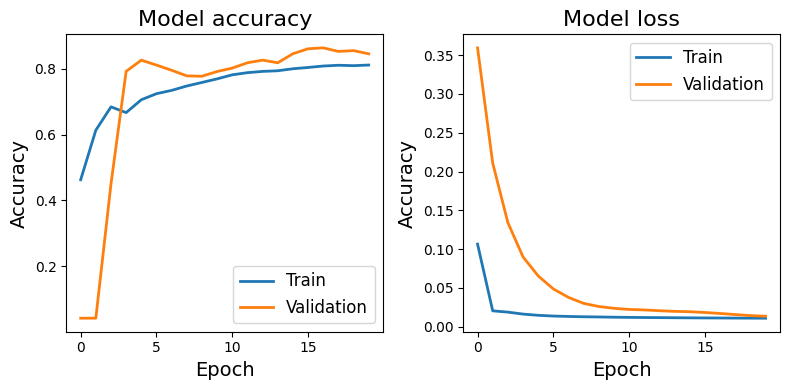

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(history_phase.history['accuracy'], linewidth=2)
plt.plot(history_phase.history['val_accuracy'], linewidth=2)
plt.title('Model accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(['Train', 'Validation'], loc='lower right',fontsize='large', title_fontsize='large')
# plt.show()

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history_phase.history['loss'], linewidth=2)
plt.plot(history_phase.history['val_loss'], linewidth=2)
plt.title('Model loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper right',fontsize='large', title_fontsize='large')
plt.tight_layout()
plt.savefig(f'{fig_path}Acc_and_loss_curves_detection.png')
plt.show()

In [11]:
from keras.models import load_model

# picking_model = load_model(f'{save_model_path}EQ_picking_best_model_new.h5')
test_phase_out = picking_model.predict(X_test_phase)



47/47 [==============================] - 7s 146ms/step


In [12]:
def to_numpy(array):
    array = np.array(array)
    return array


pre_indx_p = []
pre_indx_s = []
lab_indx_p = []
lab_indx_s = []
for i in range (test_phase_out.shape[0]):
    # print(y_test_phase[i, :, :0].shape)
    pre_ind_p = np.argmax(test_phase_out[i, :, 0])
    pre_ind_s = np.argmax(test_phase_out[i, :, 1])
    lab_ind_p = np.argmax(y_test_phase[i, :, 0])
    lab_ind_s = np.argmax(y_test_phase[i, :, 1])
    pre_indx_p.append(pre_ind_p)
    pre_indx_s.append(pre_ind_s)
    lab_indx_p.append(lab_ind_p)
    lab_indx_s.append(lab_ind_s) 
    
pre_indx_p = to_numpy(pre_indx_p)
pre_indx_s = to_numpy(pre_indx_s)
lab_indx_p = to_numpy(lab_indx_p)
lab_indx_s = to_numpy(lab_indx_s)

err_indx_p = lab_indx_p - pre_indx_p
err_indx_p = err_indx_p/100
err_indx_s = lab_indx_s - pre_indx_s
err_indx_s = err_indx_s/100

# xx = 2
# err_indx_p[(err_indx_p > xx) | (err_indx_p < -xx)] = 0
# err_indx_s[(err_indx_s > xx) | (err_indx_s < -xx)] = 0

mae_p = np.mean(np.abs(err_indx_p - np.mean(err_indx_p)))
sigma_p = np.std(err_indx_p)
mae_s = np.mean(np.abs(err_indx_s - np.mean(err_indx_s)))
sigma_s = np.std(err_indx_s)

print(f'MAE and $sigma$ of p: {mae_p:.4f}s\t{sigma_p:.4f}s\nMAE and $sigma$ of s: {mae_s:.4f}s\t{sigma_s:.4f}s')


MAE and $sigma$ of p: 2.9011s	5.7200s
MAE and $sigma$ of s: 1.4900s	5.2832s


In [ ]:
err_indx_s/100

In [ ]:
np.mean(np.abs(err_indx_s - np.mean(err_indx_s)))

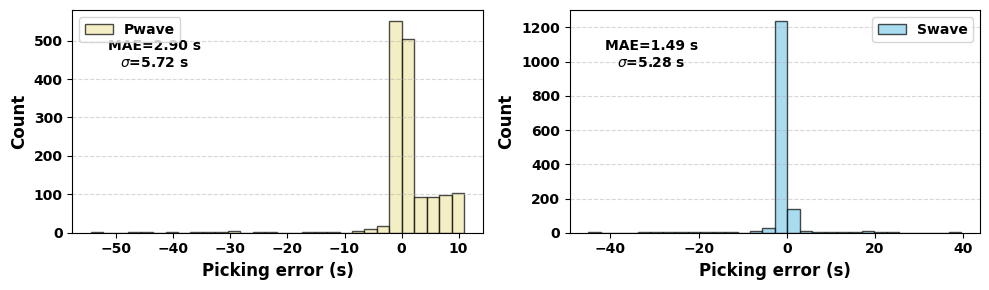

In [13]:
plt.figure(figsize=(10, 3))  # Set figure size
ax = plt.subplot(121)
plt.hist(err_indx_p, bins=30, color='palegoldenrod', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_p:.2f} s\n$\sigma$={sigma_p:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Pwave'], prop={'weight': 'bold'})

ax = plt.subplot(122)
plt.hist(err_indx_s, bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_s:.2f} s\n$\sigma$={sigma_s:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Swave'], prop={'weight': 'bold'})

plt.tight_layout()

plt.savefig(f'{fig_path}Arrival_picking_testing_data.png')
plt.show()

In [14]:
## Define fancy visualization functions

def plot_labels_signals(signal, p_predict, s_predict, p_labels, s_labels, sample_num):
    data = signal
    p_predict_indx = np.argmax(p_predict)
    s_predict_indx = np.argmax(s_predict)
    s_labels_indx = np.argmax(s_labels)
    p_labels_indx = np.argmax(p_labels)
    
    time = np.linspace(0, sample_num, sample_num)
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(511)
    plt.plot(time, data[:,0], 'k',label='Z')
    ymin,ymax = ax1.get_ylim()
    # plt.vlines(spt,ymin,yma,color='r',linewidth=2)
    # plt.vlines(sst,ymin,yma,color='b',linewidth=2)
    legend_properties = {'weight':'bold'}
    # ymin, ymax = ax1.get_ylim()
    print('ymin, ymax:', ymin, ymax)
    plt.vlines(p_labels_indx,ymin+0.2,ymax-0.2,color='deepskyblue',linewidth=2)
    plt.vlines(s_labels_indx,ymin+0.2,ymax-0.2,color='tomato',linewidth=2)
    plt.vlines(p_predict_indx,ymin,ymax,color='tomato',linewidth=2, linestyle='--')
    plt.vlines(s_predict_indx,ymin,ymax,color='deepskyblue',linewidth=2, linestyle='--')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Amplitude', fontsize=12)
    plt.xlim([0, 6000])
    ax1.set_xticklabels([])
    # ax1.set_xticks([])
    
    ax = fig.add_subplot(512) 
    plt.plot(time, data[:,1], 'k',label='N')
    # ymin,ymax = ax1.get_ylim()
    plt.vlines(p_labels_indx,ymin+0.2,ymax-0.2,color='deepskyblue',linewidth=2)
    plt.vlines(s_labels_indx,ymin+0.2,ymax-0.2,color='tomato',linewidth=2)
    plt.vlines(p_predict_indx,ymin,ymax,color='tomato',linewidth=2, linestyle='--')
    plt.vlines(s_predict_indx,ymin,ymax,color='deepskyblue',linewidth=2, linestyle='--')
    legend_properties = {'weight':'bold'}
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Amplitude', fontsize=12) 
    plt.xlim([0, 6000])
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(513) 
    plt.plot(time, data[:,2], 'k',label='E')
    # ymin,yma = ax1.get_ylim()
    # plt.vlines(spt,ymin,yma,color='r',linewidth=2)
    # plt.vlines(sst,ymin,yma,color='b',linewidth=2)
    legend_properties = {'weight':'bold'}
    # ymin, ymax = ax.get_ylim()
    plt.vlines(p_labels_indx,ymin+0.2,ymax-0.2,color='deepskyblue',linewidth=2)
    plt.vlines(s_labels_indx,ymin+0.2,ymax-0.2,color='tomato',linewidth=2)
    plt.vlines(p_predict_indx,ymin,ymax,color='tomato',linewidth=2, linestyle='--')
    plt.vlines(s_predict_indx,ymin,ymax,color='deepskyblue',linewidth=2, linestyle='--')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Amplitude', fontsize=12) 
    plt.xlim([0, 6000])
    # plt.ylim([-1, 1])
    ymin,yma = ax.get_ylim()
    ax.set_xticklabels([])
    # ax.set_xticks([])
    
    ax = fig.add_subplot(514) 
    plt.plot(time, p_predict, label='P-wave predicted', linestyle='--')
    plt.plot(time, s_predict, label='S-wave predicted', linestyle='--')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Probability', fontsize=12) 
    # plt.xlabel('Sample', fontsize=12) 
    plt.xlim([0, 6000])
    # plt.ylim([-1, 1])
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(515) 
    plt.plot(time, p_labels, label='P-wave label', linestyle='--')
    plt.plot(time, s_labels, label='S-wave label', linestyle='--')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Probability', fontsize=12) 
    plt.xlabel('Sample', fontsize=12) 
    plt.xlim([0, 6000])
    plt.tight_layout()

(1500, 6000, 2)
ymin, ymax: -1.4062203047810837 1.1145819192752897


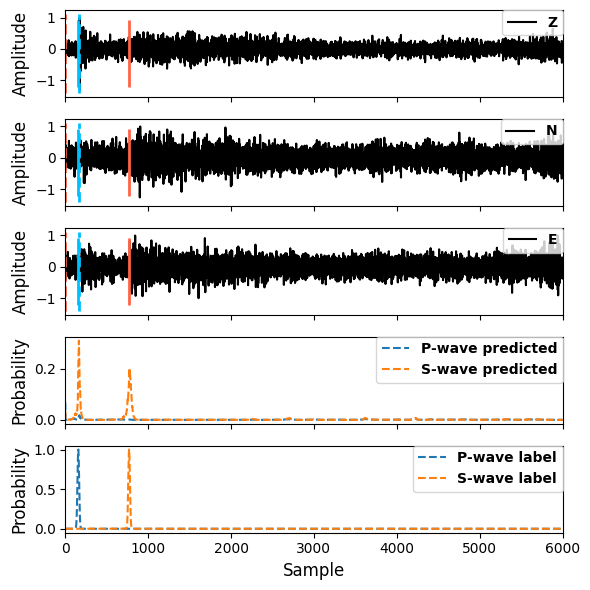

In [15]:
print(test_phase_out.shape)

m = 10

# def plot_labels_signals(signal, p_predict, s_predict, p_labels, s_labels, sample_num):
plot_labels_signals(X_test_phase[m, :, :], p_predict=test_phase_out[m, :, 0], s_predict=test_phase_out[m, :, 1], p_labels=y_test_phase[m, :, 0], s_labels=y_test_phase[m, :, 1], sample_num=6000)
# plt.savefig(f'./figs/phase_picking/p_and_s_wave/p_and_swave_picking_testing_num_{m}.pdf', bbox_inches="tight", dpi=300)
# plt.savefig(f'./figs/phase_picking/p_and_s_wave/p_and_swave_picking_testing_num_{m}.png', bbox_inches="tight", dpi=300)
plt.show()



In [16]:
train_phase_out = picking_model.predict(X_train_phase)
print(train_phase_out.shape)

266/266 [==============================] - 39s 145ms/step
(8500, 6000, 2)


In [17]:
pre_indx_p = []
pre_indx_s = []
lab_indx_p = []
lab_indx_s = []
for i in range (test_phase_out.shape[0]):
    # print(y_test_phase[i, :, :0].shape)
    pre_ind_p = np.argmax(train_phase_out[i, :, 0])
    pre_ind_s = np.argmax(train_phase_out[i, :, 1])
    lab_ind_p = np.argmax(y_train_phase[i, :, 0])
    lab_ind_s = np.argmax(y_train_phase[i, :, 1])
    pre_indx_p.append(pre_ind_p)
    pre_indx_s.append(pre_ind_s)
    lab_indx_p.append(lab_ind_p)
    lab_indx_s.append(lab_ind_s) 
    
pre_indx_p = to_numpy(pre_indx_p)
pre_indx_s = to_numpy(pre_indx_s)
lab_indx_p = to_numpy(lab_indx_p)
lab_indx_s = to_numpy(lab_indx_s)

pre_indx_p = to_numpy(pre_indx_p)
pre_indx_s = to_numpy(pre_indx_s)
lab_indx_p = to_numpy(lab_indx_p)
lab_indx_s = to_numpy(lab_indx_s)

err_indx_p = lab_indx_p - pre_indx_p
err_indx_p_train = err_indx_p/100
err_indx_s = lab_indx_s - pre_indx_s
err_indx_s_train = err_indx_s/100


# xx = 2
# err_indx_p_train[(err_indx_p_train > xx) | (err_indx_p_train < -xx)] = 0
# err_indx_s_train[(err_indx_s_train > xx) | (err_indx_s_train < -xx)] = 0
mae_p = np.mean(np.abs(err_indx_p_train - np.mean(err_indx_p_train)))
sigma_p = np.std(err_indx_p_train)
mae_s = np.mean(np.abs(err_indx_s_train - np.mean(err_indx_s_train)))
sigma_s = np.std(err_indx_s_train)


print(f'MAE and $sigma$ of p: {mae_p:.4f}s\t{sigma_p:.4f}s\nMAE and $sigma$ of s: {mae_s:.4f}s\t{sigma_s:.4f}s')

MAE and $sigma$ of p: 2.7359s	4.8377s
MAE and $sigma$ of s: 1.4759s	5.1832s


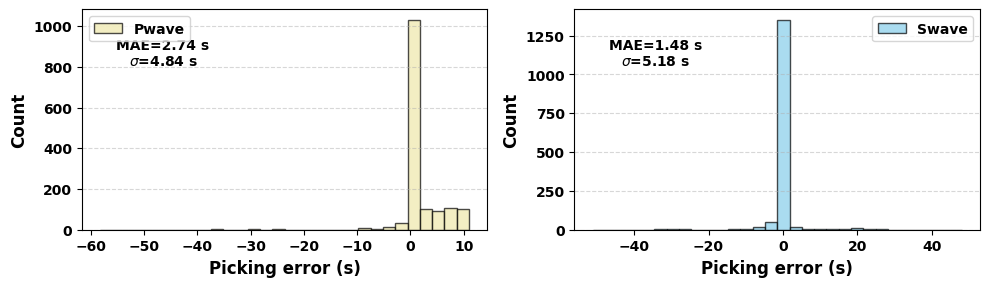

In [18]:
plt.figure(figsize=(10, 3))  # Set figure size
ax = plt.subplot(121)
plt.hist(err_indx_p_train, bins=30, color='palegoldenrod', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_p:.2f} s\n$\sigma$={sigma_p:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Pwave'], prop={'weight': 'bold'})

ax = plt.subplot(122)
plt.hist(err_indx_s_train, bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_s:.2f} s\n$\sigma$={sigma_s:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Swave'], prop={'weight': 'bold'})

plt.tight_layout()

plt.savefig(f'{fig_path}Arrival_picking_training_data.png')
plt.show()

ymin, ymax: -1.1730294162789618 1.1034775912513792


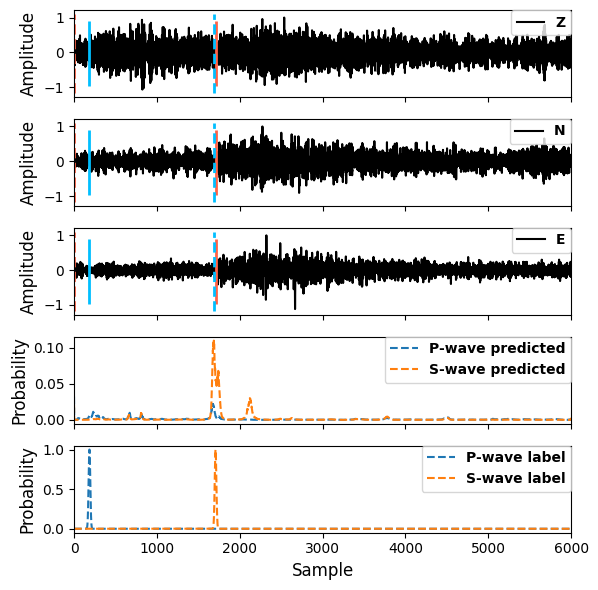

In [19]:
m = 600

plot_labels_signals(X_train_phase[m, :, :], p_predict=train_phase_out[m, :, 0], s_predict=train_phase_out[m, :, 1], p_labels=y_train_phase[m, :, 0], s_labels=y_train_phase[m, :, 1], sample_num=6000)
plt.show()

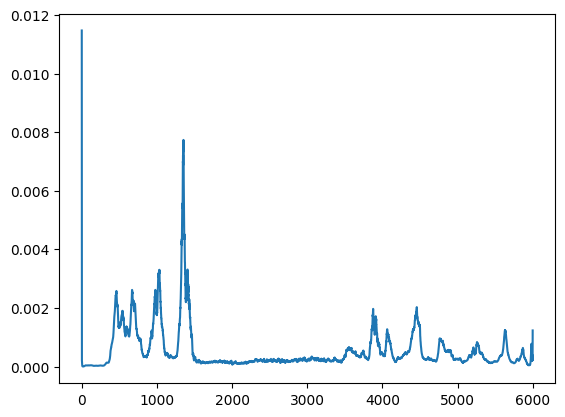

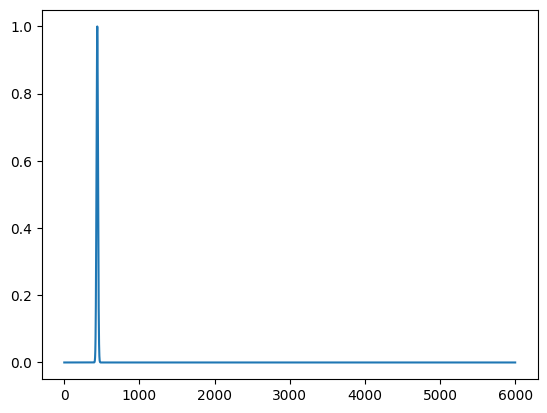

In [20]:
plt.figure()
plt.plot(test_phase_out[20, :, 0])

plt.figure()
plt.plot(y_test_phase[20, :, 0])

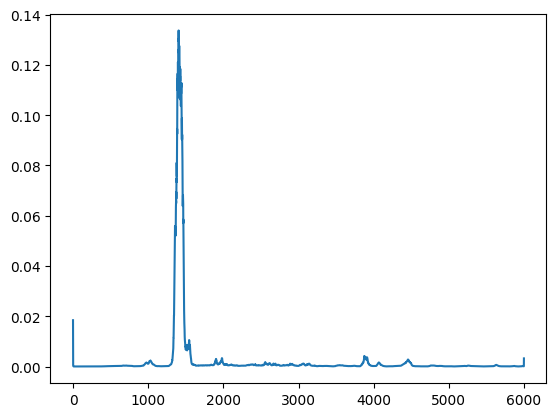

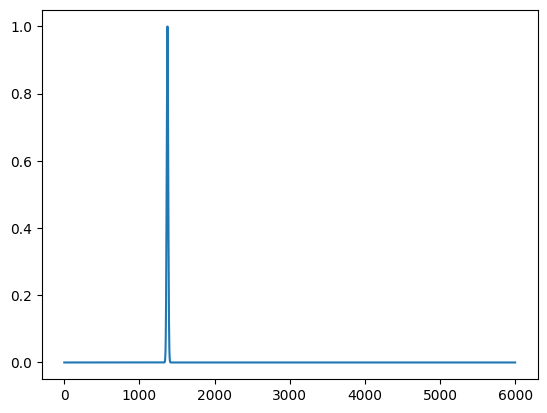

In [21]:
plt.figure()
plt.plot(test_phase_out[20, :, 1])

plt.figure()
plt.plot(y_test_phase[20, :, 1])